In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint
seed = 0

sns.set_style('whitegrid')

In [2]:
def shape(down,up,plug_in):
    return (up-plug_in)/(plug_in-down)

def length(down, up):
    return up-down

In [3]:
def bootstrapped_statistics(x_stars, statistic):
    thetas = np.empty(len(x_stars))
    for i,x_star in enumerate(x_stars):
        thetas[i] = statistic(x_star)
    return thetas

In [4]:
def bootstrap_samples(sampling_distribution, X, B):
    X_star = np.empty(shape=(B,len(X)))
    for i in range(B):
        X_star[i] = X[sampling_distribution.rvs(size=len(X))]
    return X_star

In [5]:
def plug_in_estimate(X, statistic):
    return statistic(X)

In [6]:
def get_bootstrap_percentile(Z_star, alpha, B):
    idx = int(np.floor(alpha*B))
    return Z_star[idx]

In [7]:
def bootstrap_samples(sampling_distribution, X, B):
    X_star = np.empty(shape=(B,len(X)))
    for i in range(B):
        X_star[i] = X[sampling_distribution.rvs(size=len(X))]
    return X_star

In [8]:
def se_boot(X, statistic, B,sampling_distribution):
    T_star_arr = np.empty(shape=(B))
    for i in range(B):
        idx = sampling_distribution.rvs(size=len(X))
        T_star_arr[i] = statistic(X[idx])
    return np.sqrt((1/(B-1))*np.sum((T_star_arr-T_star_arr.mean()*np.ones(B))**2))

In [9]:
def percentile_interval(bootstrapped_statistics, alpha):
    bootstrapped_statistics = np.sort(bootstrapped_statistics)
    return bootstrapped_statistics[int(len(bootstrapped_statistics)*alpha/2//1)], bootstrapped_statistics[int(len(bootstrapped_statistics)*(1-alpha/2)//1)]

In [10]:
def bootstrap_t_interval(X, statistic, bootstrap_samples, sampling_distribution, alpha = 0.05):
    B = len(bootstrap_samples)
    
    X_hat = plug_in_estimate(X,statistic)
    std_hat = se_boot(X, statistic, B, sampling_distribution)
    
    X_star = bootstrap_samples
    T_star = np.array(list(map(lambda x: statistic(x), X_star)))
    se_boot_arr = np.array(list(map(lambda x: se_boot(x, statistic, B,sampling_distribution), X_star)))
    Z_star = (T_star -X_hat*np.ones_like(T_star))/se_boot_arr

    Z_star = np.sort(Z_star)
    
    t_1_min_alpha_2 = Z_star[int((B*(1-alpha/2))//1)]
    t_alpha_2 = Z_star[int((B*alpha/2)//1)]
    
    return X_hat-t_1_min_alpha_2*std_hat, X_hat-t_alpha_2*std_hat

In [11]:
def jacknife_samples(X):
    arr = []
    for i in range(len(X)):
        arr.append(np.append(X[:i], X[i+1:]))
    return np.array(arr)

In [12]:
def acceleration(shanked_statistics):
    n = len(shanked_statistics)
    shanked_mean = shanked_statistics.mean()*np.ones(n)
    denominator = np.sum((shanked_mean-shanked_statistics)**3)
    nominator = (np.sum((shanked_mean-shanked_statistics)**2)**(3/2))*6
    return denominator/nominator

In [13]:
from statistics import NormalDist
def bias_correction(boostrapped_stats, plug_in_estimation, B):
    logic_arr = boostrapped_stats < plug_in_estimation
    return NormalDist(mu=0, sigma=1).inv_cdf(np.sum(logic_arr)/B)

In [14]:
from statistics import NormalDist
def BCa_alphas(z_0, acc, alpha):
    standard_normal = NormalDist(mu=0, sigma=1)
    alpha_one = standard_normal.cdf(z_0+(z_0+standard_normal.inv_cdf(alpha/2))/(1-acc*(z_0+standard_normal.inv_cdf(alpha/2))))
    alpha_two = standard_normal.cdf(z_0+(z_0+standard_normal.inv_cdf(1-alpha/2))/(1-acc*(z_0+standard_normal.inv_cdf(1-alpha/2))))
    return alpha_one, alpha_two

In [15]:
def BCa_interval(X, bootstrap_samples, statistic, alpha):
    X_star = bootstrap_samples
    X_hat = statistic(X)
    T_star = np.array(list(map(lambda x: statistic(x), X_star)))
    T_star = np.sort(T_star)
    B = len(X_star)
    shanked_samples = jacknife_samples(X)
    acc = acceleration(np.array(list(map(lambda x: statistic(x), shanked_samples))))
    z_0 = bias_correction(T_star, X_hat, B)
    alpha_1, alpha_2 = BCa_alphas(z_0, acc, alpha)
    return T_star[int(B*alpha_1//1)], T_star[int(B*alpha_2//1)]

### Chapter 3

In [16]:
np.random.seed(seed=seed)

In [17]:
wine = pd.read_csv('../winequality-red.csv')

In [18]:
np.random.seed(seed=seed)
wine = wine.iloc[np.random.choice(range(len(wine)), size=30, replace=False)]

In [19]:
test_df = pd.read_csv('../winequality-red.csv')
np.random.seed(seed=seed)
valid = list(set(range(len(test_df))).difference(set(np.random.choice(range(len(test_df)), size=50, replace=False))))

np.random.seed(seed=seed)
test_indexes = np.random.choice(valid, size=50, replace=False)
X_test, y_test = test_df[test_df.columns[:-1]].iloc[test_indexes], test_df[test_df.columns[-1]].iloc[test_indexes]

In [20]:
wine.index = range(len(wine))

In [21]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,8.120000,0.546333,0.257000,2.581667,0.078500,13.833333,45.766667,0.996209,3.326667,0.604000,10.563333,5.533333
std,1.672166,0.189090,0.154321,2.084362,0.030057,11.098566,36.324859,0.001826,0.181855,0.108995,1.146955,0.860366
min,5.000000,0.280000,0.000000,1.300000,0.034000,3.000000,6.000000,0.992100,3.120000,0.420000,9.000000,4.000000
25%,7.150000,0.385000,0.115000,1.800000,0.060000,5.000000,19.250000,0.995170,3.200000,0.522500,9.625000,5.000000
50%,8.200000,0.525000,0.260000,2.075000,0.075000,7.500000,30.000000,0.996600,3.295000,0.605000,10.300000,5.500000
75%,9.250000,0.643750,0.375000,2.475000,0.086750,20.750000,64.500000,0.997493,3.360000,0.640000,11.475000,6.000000
max,12.200000,1.040000,0.490000,12.900000,0.171000,41.000000,133.000000,0.998800,3.900000,0.850000,12.800000,7.000000


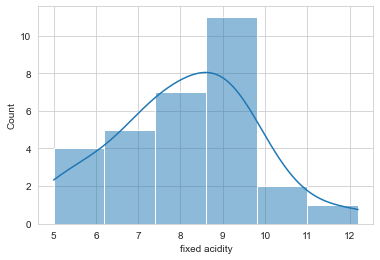

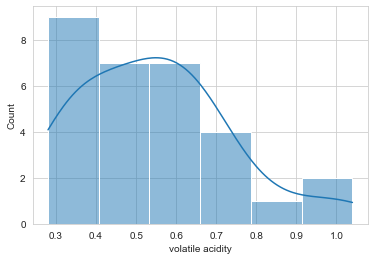

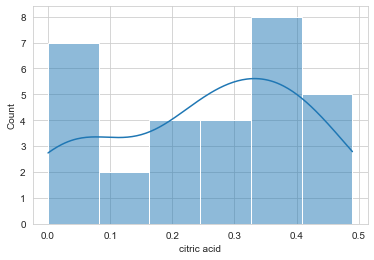

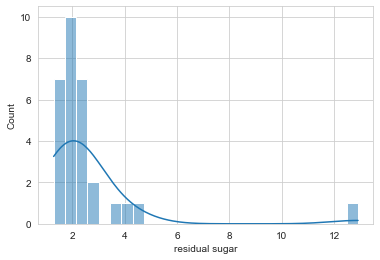

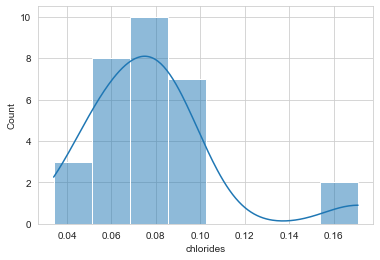

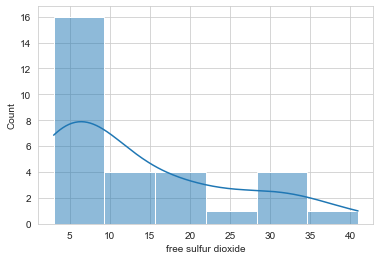

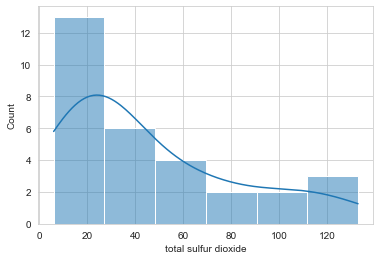

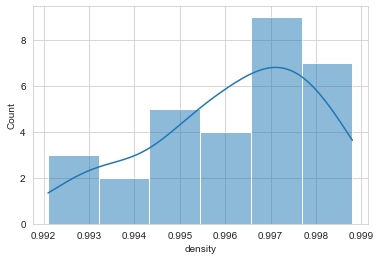

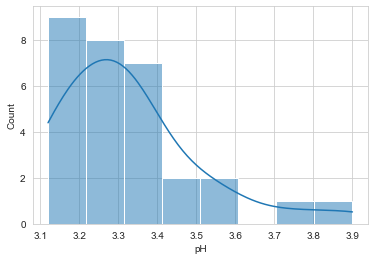

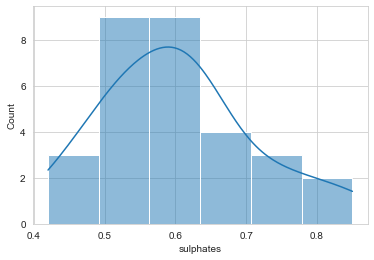

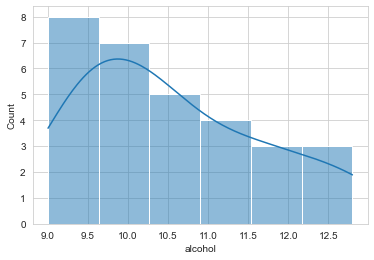

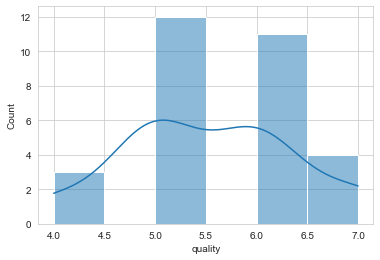

In [22]:
for col in wine.columns:
    sns.histplot(wine[col], kde=True)
    plt.show()

In [23]:
X = wine[wine.columns[:-1]]
y = wine[wine.columns[-1]]

In [24]:
cols_with_nan = ['volatile acidity', 'total sulfur dioxide', 'sulphates']

In [25]:
sed = 0
for col in cols_with_nan:
    np.random.seed(seed=sed)
    sed +=1
    wine[col].iloc[np.random.choice(range(len(wine)), size=5, replace=False)] = wine[col].iloc[np.random.choice(range(len(wine)), size=5, replace=False)]*np.nan

In [26]:
wine.isna().sum()

fixed acidity           0
volatile acidity        5
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    5
density                 0
pH                      0
sulphates               5
alcohol                 0
quality                 0
dtype: int64

In [27]:
len(wine.dropna())

16

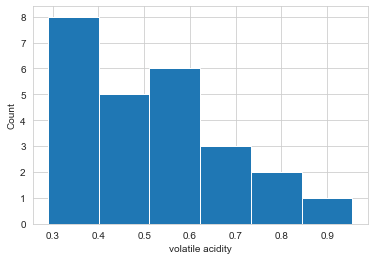

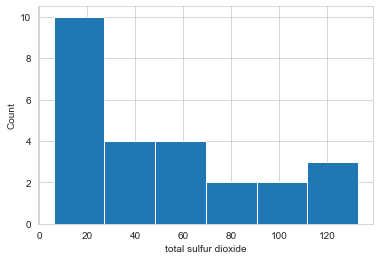

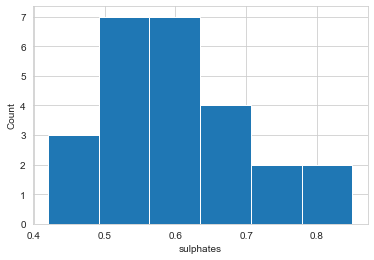

In [28]:
for col in cols_with_nan:
    sns.histplot(wine[col], alpha = 1)
    plt.xlabel(col)
    plt.show()

In [29]:
len(wine)

30

In [30]:
len(wine.dropna())

16

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
whole_data = LinearRegression().fit(X,y)

In [33]:
print(f"R_squared = {whole_data.score(X,y)}")

R_squared = 0.7386473031721983


In [34]:
X_dropped, y_dropped = wine.dropna()[wine.columns[:-1]], wine.dropna()[wine.columns[-1]]
X_dropped.index = range(len(X_dropped))
y_dropped.index = range(len(y_dropped))
dropped_data= LinearRegression().fit(X_dropped,y_dropped)
print(f"R_squared = {dropped_data.score(X_dropped,y_dropped)}")

R_squared = 0.9256666216345317


In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
print(mean_squared_error(y_test, whole_data.predict(X_test)))
print(mean_squared_error(y_test, dropped_data.predict(X_test)))

1.3609701863322874
2.25958087625573


In [37]:
B=100
alpha=0.05

In [38]:
nan_bootstrap_samples = []
for col in cols_with_nan:
    nan_bootstrap_samples.append(bootstrap_samples(randint(low = 0, high=len(X_dropped)), X_dropped[col], B=B))

In [39]:
bootstrap_t_intervals = []
percentile_intervals = []
bca_intervals = []
for sample, col in zip(nan_bootstrap_samples, cols_with_nan):
    l1,u1 = bootstrap_t_interval(X_dropped[col], lambda x: x.mean(), sample, randint(low = 0, high=len(X_dropped)), alpha=alpha)
    bootstrap_t_intervals.append((l1,u1))
    l2,u2 = percentile_interval(np.array(list(map(lambda x: x.mean(), sample))), alpha=alpha)
    percentile_intervals.append((l2,u2))
    l3,u3 = BCa_interval(X_dropped[col], sample, lambda x: x.mean(), alpha=alpha)
    bca_intervals.append((l3,u3))

In [40]:
for interval, col in zip(bootstrap_t_intervals, cols_with_nan):
    print(f"bootstrap-t: {interval}")
    print(f"Sample mean = {X_dropped[col].mean()}")
    print(f"shape = {shape(interval[0], interval[1], X_dropped[col].mean())}  length = {length(interval[0], interval[1])}")
    print(interval[0] < X_dropped[col].mean() and interval[1] > X_dropped[col].mean())
    print()


bootstrap-t: (0.46368968599852356, 0.6648544744380825)
Sample mean = 0.5421875
shape = 1.5626801331789344  length = 0.20116478843955898
True

bootstrap-t: (33.896455194441835, 66.83108825358491)
Sample mean = 49.4375
shape = 1.1192032756616332  length = 32.934633059143074
True

bootstrap-t: (0.5049648787724329, 0.653147615000492)
Sample mean = 0.5774999999999999
shape = 1.0429101615913783  length = 0.1481827362280591
True



In [41]:
for interval, col in zip(percentile_intervals, cols_with_nan):
    print(f"Percentile: {interval}")
    print(f"Sample mean = {X_dropped[col].mean()}")
    print(f"shape = {shape(interval[0], interval[1], X_dropped[col].mean())}  length = {length(interval[0], interval[1])}")
    print(interval[0] < X_dropped[col].mean() and interval[1] > X_dropped[col].mean())
    print()


Percentile: (0.453125, 0.63375)
Sample mean = 0.5421875
shape = 1.028070175438596  length = 0.18062500000000004
True

Percentile: (34.6875, 70.8125)
Sample mean = 49.4375
shape = 1.4491525423728813  length = 36.125
True

Percentile: (0.52, 0.639375)
Sample mean = 0.5774999999999999
shape = 1.0760869565217435  length = 0.11937500000000001
True



In [42]:
for interval, col in zip(bca_intervals, cols_with_nan):
    print(f"BCa: {interval}")
    print(f"Sample mean = {X_dropped[col].mean()}")
    print(f"shape = {shape(interval[0], interval[1], X_dropped[col].mean())}  length = {length(interval[0], interval[1])}")
    print(interval[0] < X_dropped[col].mean() and interval[1] > X_dropped[col].mean())
    print()

BCa: (0.4434375, 0.6303125)
Sample mean = 0.5421875
shape = 0.8924050632911388  length = 0.18687500000000007
True

BCa: (38.375, 82.4375)
Sample mean = 49.4375
shape = 2.983050847457627  length = 44.0625
True

BCa: (0.53375, 0.65375)
Sample mean = 0.5774999999999999
shape = 1.742857142857148  length = 0.1200000000000001
True



In [43]:
filled_t, filled_p, filled_bca = wine.copy(), wine.copy(), wine.copy()
for intervals, df in zip([bootstrap_t_intervals, percentile_intervals, bca_intervals], [filled_t, filled_p, filled_bca]):
    print('...')
    for interval, col in zip(intervals, cols_with_nan):
        print(f"\t{col} = ", end="")
        np.random.seed(seed=seed)
        generated_data = np.random.uniform(low=interval[0], high=interval[1], size=len(df[df[col].isnull()]))
        print(generated_data)
        print()
        
        indexes_to_fill = df[df[col].isnull()][col].index
        df.loc[indexes_to_fill, col] = generated_data

...
	volatile acidity = [0.57409164 0.6075606  0.58494445 0.573301   0.54891411]

	total sulfur dioxide = [51.97142656 57.45095454 53.74824581 51.84198289 47.84937055]

	sulphates = [0.58628957 0.6109436  0.59428401 0.58570716 0.56774321]

...
	volatile acidity = [0.55225444 0.58230608 0.56199913 0.55154452 0.52964765]

	total sulfur dioxide = [54.51338783 60.52371586 56.46232696 54.37140499 49.99202963]

	sulphates = [0.58551461 0.60537573 0.59195488 0.58504543 0.57057379]

...
	volatile acidity = [0.54599702 0.57708851 0.55607891 0.54526254 0.52260799]

	total sulfur dioxide = [62.55709502 69.88803146 64.93426126 62.38391525 57.0422896 ]

	sulphates = [0.59960762 0.61957272 0.60608161 0.59913598 0.58458858]



In [44]:
filled_mean = wine.copy()
for col in cols_with_nan:
    print(f"\t{col} = ", end="")
    generated_data = np.ones(filled_mean[col].isnull().sum(),)*filled_mean[col].mean()
    print(generated_data)
    print()
    
    indexes_to_fill = filled_mean[filled_mean[col].isnull()][col].index
    filled_mean.loc[indexes_to_fill, col] = generated_data

	volatile acidity = [0.5222 0.5222 0.5222 0.5222 0.5222]

	total sulfur dioxide = [49.4 49.4 49.4 49.4 49.4]

	sulphates = [0.6016 0.6016 0.6016 0.6016 0.6016]



In [45]:
X_y_filled = []
linear_models = []
for df in [filled_t, filled_p, filled_bca]:
    X_t, y_t= df[wine.columns[:-1]], df[wine.columns[-1]]
    X_y_filled.append((X_t,y_t))
    linear_models.append(LinearRegression().fit(X_t,y_t))
X_t, y_t= filled_mean[wine.columns[:-1]], filled_mean[wine.columns[-1]]
linear_models.append(LinearRegression().fit(X_t,y_t))

In [46]:
ground_truth = mean_squared_error(y_test, whole_data.predict(X_test))
for model, fill_method in zip(linear_models, ['bootstrap_t', 'percentile', 'bca', 'mean']):
    print(f"{fill_method} rmse = ", end='')
    computed_rmse = mean_squared_error(y_test, model.predict(X_test))
    print(computed_rmse)
    deviation_from_truth = 100*np.abs(ground_truth-computed_rmse)/ground_truth
    print(f"{deviation_from_truth}% away from rmse computed for the original data")
    print()
print("Dropped data rmse = ", end="")
print(mean_squared_error(y_test, dropped_data.predict(X_test)))
deviation_from_truth = 100*np.abs(ground_truth-mean_squared_error(y_test, dropped_data.predict(X_test)))/ground_truth
print(f"{deviation_from_truth}% away from rmse computed for the original data")
print()
print("Ground truth rmse = ", end="")
print(ground_truth)


bootstrap_t rmse = 1.4198004875882615
4.3226737695494535% away from rmse computed for the original data

percentile rmse = 1.4073553325480008
3.4082411710074214% away from rmse computed for the original data

bca rmse = 1.3844938451915243
1.7284477717055216% away from rmse computed for the original data

mean rmse = 1.4185460061843178
4.23049824531373% away from rmse computed for the original data

Dropped data rmse = 2.25958087625573
66.02721345021753% away from rmse computed for the original data

Ground truth rmse = 1.3609701863322874


In [47]:
print(cols_with_nan)
print(wine.columns[-1])

['volatile acidity', 'total sulfur dioxide', 'sulphates']
quality


In [48]:
#for col in cols_with_nan:
#    for lm, fill_method, df in zip(linear_models, ['bootstrap_t', 'percentile', 'bca', 'mean'], [filled_t, filled_p, filled_bca, filled_mean]):
#        coef_index = list(wine.columns).index(col)
#        intercept, coef = lm.intercept_, lm.coef_[coef_index]
#        x_arr = np.array(df[col])
#        y_arr = np.array(df['quality'])
#        intercept = np.ones_like(x_arr)
#        sns.scatterplot(x_arr, y_arr, label=fill_method)
#        sns.lineplot(intercept+coef*x_arr, y_arr)
#    plt.xlabel(col)
#    plt.ylabel("QUALITY")
#    plt.yticks(np.sort(np.unique(y_arr)))
#    plt.show()

In [49]:
cols_with_nan

['volatile acidity', 'total sulfur dioxide', 'sulphates']

In [50]:
results_table = pd.DataFrame(columns=cols_with_nan)

In [51]:
results_table

,volatile acidity,total sulfur dioxide,sulphates


In [52]:
intervals

[(0.4434375, 0.6303125), (38.375, 82.4375), (0.53375, 0.65375)]

In [53]:
bootstrap_t_intervals

[(0.46368968599852356, 0.6648544744380825),
 (33.896455194441835, 66.83108825358491),
 (0.5049648787724329, 0.653147615000492)]

In [54]:
percentile_intervals

[(0.453125, 0.63375), (34.6875, 70.8125), (0.52, 0.639375)]

In [55]:
bca_intervals

[(0.4434375, 0.6303125), (38.375, 82.4375), (0.53375, 0.65375)]

In [56]:
wine[cols_with_nan].mean()

volatile acidity         0.5222
total sulfur dioxide    49.4000
sulphates                0.6016
dtype: float64

In [57]:
for intervals, name in zip([bootstrap_t_intervals,percentile_intervals,bca_intervals], ['Bootstrap-t',\
    "Percentile", "BCa"]):
    print(name)
    for interval, array_mean, col in zip(intervals, [0.5222, 49.4000, 0.6016], cols_with_nan):
        print(f"\tColumn = {col}")
        print(f"\t\tShape = {shape(interval[0], interval[1], array_mean)}")
        print(f"\t\tLength = {length(interval[0], interval[1])}")

Bootstrap-t
	Column = volatile acidity
		Shape = 2.4381081672965013
		Length = 0.20116478843955898
	Column = total sulfur dioxide
		Shape = 1.124329208074769
		Length = 32.934633059143074
	Column = sulphates
		Shape = 0.533425263461945
		Length = 0.1481827362280591
Percentile
	Column = volatile acidity
		Shape = 1.6149113282663778
		Length = 0.18062500000000004
	Column = total sulfur dioxide
		Shape = 1.4553950722175024
		Length = 36.125
	Column = sulphates
		Shape = 0.46292892156862747
		Length = 0.11937500000000001
BCa
	Column = volatile acidity
		Shape = 1.3726392636089515
		Length = 0.18687500000000007
	Column = total sulfur dioxide
		Shape = 2.9965986394557826
		Length = 44.0625
	Column = sulphates
		Shape = 0.7686072218128219
		Length = 0.1200000000000001


Boostrapping Residuals

In [58]:
X_t, y_t= filled_bca[wine.columns[:-1]], filled_bca[wine.columns[-1]]
bca_lm = LinearRegression().fit(X_t,y_t)

In [59]:
y_pred = bca_lm.predict(X_test)

In [60]:
mean_squared_error(y_test, y_pred)

1.3844938451915243

In [61]:
def bootstrap_residuals(X_df, y_df, residuals, percentage_new_data = .5):
    np.random.seed(seed=0)
    indexes = np.random.randint(low=0, high=len(X_df)+1, size=(int(len(X_df)*percentage_new_data),))
    X_to_append = X_df.iloc[indexes].copy()
    y_to_append = y_df.iloc[indexes].copy() + residuals[indexes]
    return pd.concat([X_df, X_to_append], ignore_index=True), pd.concat([y_df, y_to_append], ignore_index=True)

In [62]:
X_appended, y_appended = bootstrap_residuals(X_t, y_t, bootstrapped_residuals, percentage_new_data = .5)

NameError: name 'bootstrapped_residuals' is not defined

In [ ]:
rmse_array = []
deviations = []
for percentage in np.linspace(0,1,11)[1:]:
    X_appended, y_appended = bootstrap_residuals(X_t, y_t, bootstrapped_residuals, percentage_new_data = percentage)
    model = LinearRegression().fit(X_appended, y_appended)
    prediction = model.predict(X_test)
    root_mse = mean_squared_error(y_test, prediction)
    rmse_array.append(root_mse)
    deviations.append(np.abs(ground_truth-root_mse)/ground_truth)

In [63]:
sns.scatterplot(np.linspace(0,1,11)[1:], deviations)

NameError: name 'deviations' is not defined

In [64]:
sns.scatterplot(np.linspace(0,1,11)[1:], rmse_array)

NameError: name 'rmse_array' is not defined

In [65]:
print(np.array(rmse_array).min())
print(np.linspace(0,1,11)[1:][np.array(rmse_array).argmin()])

NameError: name 'rmse_array' is not defined

In [66]:
int(len(X_t)*0.3) + len(X_t)

39

In [67]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
2,9.1,0.290,0.33,2.05,0.063,13.0,NaN,0.99516,3.26,0.84,11.7,7
3,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6
4,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5
5,8.2,NaN,0.27,2.00,0.095,5.0,77.0,0.99747,3.13,0.62,9.1,6
6,9.3,NaN,0.24,2.10,0.070,5.0,20.0,0.99660,3.12,0.59,9.9,5
7,9.3,0.360,0.39,1.50,0.080,41.0,55.0,0.99652,3.47,0.73,10.9,6
8,8.8,0.955,0.05,1.80,0.075,5.0,19.0,0.99616,3.30,0.44,9.6,4
9,7.1,0.735,0.16,1.90,0.100,15.0,77.0,0.99660,3.27,0.64,9.3,5


In [68]:
test_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [69]:
y_test

155     5
1138    5
1087    6
1019    5
1349    5
868     6
151     4
421     7
619     5
595     5
55      5
116     6
1578    6
258     5
1428    5
544     6
110     5
401     6
1262    5
445     6
68      5
325     6
980     6
817     6
1388    5
1196    6
540     5
1025    6
1209    7
1529    6
20      6
9       5
507     6
384     5
992     6
423     7
968     6
1082    6
1102    6
922     6
635     5
1406    6
888     6
259     7
533     6
996     7
56      5
420     7
1528    6
772     5
Name: quality, dtype: int64

In [70]:
X_dropped

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,10.8,0.470,0.43,2.1,0.171,27.0,66.0,0.99820,3.17,0.76,10.8
1,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6
2,10.2,0.645,0.36,1.8,0.053,5.0,14.0,0.99820,3.17,0.42,10.0
3,12.2,0.450,0.49,1.4,0.075,3.0,6.0,0.99690,3.13,0.63,10.4
4,9.3,0.360,0.39,1.5,0.080,41.0,55.0,0.99652,3.47,0.73,10.9
5,8.8,0.955,0.05,1.8,0.075,5.0,19.0,0.99616,3.30,0.44,9.6
6,7.1,0.735,0.16,1.9,0.100,15.0,77.0,0.99660,3.27,0.64,9.3
7,8.6,0.520,0.38,1.5,0.096,5.0,18.0,0.99666,3.20,0.52,9.4
8,9.4,0.500,0.34,3.6,0.082,5.0,14.0,0.99870,3.29,0.52,10.7
9,7.5,0.310,0.41,2.4,0.065,34.0,60.0,0.99492,3.34,0.85,11.4


#### Bootstrap Aggregating (Bagging)

randint(low = 0, high=len(X_dropped)), X_dropped[col], B=B))

In [71]:
X_bca, y_bca = filled_bca[wine.columns[:-1]], filled_bca[wine.columns[-1]]

In [69]:
nrmse_arr = []
for num_models in range(1,200):
    bagging_predictions = []
    np.random.seed(seed=seed)
    for i in range(num_models):
        indexes = randint(low=0,high=len(X)).rvs(len(X))
        aux_X = X.iloc[indexes].copy()
        aux_y = y.iloc[indexes].copy()
        predictions = LinearRegression().fit(aux_X, aux_y).predict(X_test)
        bagging_predictions.append(predictions)
    
    bagging_predictions = np.array(bagging_predictions)
    aggregated_predictions = np.empty(bagging_predictions.shape[1])
    
    for i in range(bagging_predictions.shape[1]):
        aggregated_predictions[i] = bagging_predictions[:,i].mean()

    aggregated_predictions = np.empty(bagging_predictions.shape[1])
    for i in range(bagging_predictions.shape[1]):
        aggregated_predictions[i] = bagging_predictions[:,i].mean()
        
    nrmse_arr.append(mean_squared_error(y_test, aggregated_predictions))

KeyboardInterrupt: 

c:\Users\Darius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


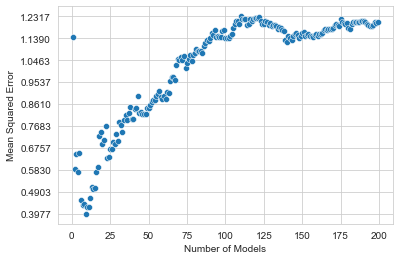

In [ ]:
nrmse_arr = np.array(nrmse_arr)
sns.scatterplot(range(1,200), nrmse_arr[:])
plt.yticks(np.linspace(nrmse_arr.min(), nrmse_arr.max(), 10));
plt.ylabel("Mean Squared Error");
plt.xlabel("Number of Models");

In [72]:
from keras.layers import Dense 
from keras import Sequential
from keras.callbacks import EarlyStopping

In [97]:
dl_model = Sequential(
    [Dense(len(X.columns), activation='relu'),
    Dense(len(X.columns)//2, activation='relu'),
    Dense(1, activation='relu')]
)
dl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [154]:
history = dl_model.fit(x=X_dropped, y=y_dropped, epochs = 10000, callbacks=[EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)], shuffle=True)

Epoch 1/10000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 0s/step - loss: 18.5138 - mse: 18.5138
Epoch 2/10000
1/1 [==============================] - 0s 1ms/step - loss: 16.2720 - mse: 16.2720
Epoch 3/10000
1/1 [==============================] - 0s 628us/step - loss: 13.9943 - mse: 13.9943
Epoch 4/10000
1/1 [==============================] - 0s 0s/step - loss: 11.9879 - mse: 11.9879
Epoch 5/10000
1/1 [==============================] - 0s 0s/step - loss: 10.3814 - mse: 10.3814
Epoch 6/10000
1/1 [==========

Epoch 165/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3322 - mse: 0.3322
Epoch 166/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3303 - mse: 0.3303
Epoch 167/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3283 - mse: 0.3283
Epoch 168/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3265 - mse: 0.3265
Epoch 169/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3247 - mse: 0.3247
Epoch 170/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3229 - mse: 0.3229
Epoch 171/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3212 - mse: 0.3212
Epoch 172/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3196 - mse: 0.3196
Epoch 173/10000
1/1 [==============================] - 0s 995us/step - loss: 0.3181 - mse: 0.3181
Epoch 174/10000
1/1 [==============================] - 0s 999us/step - loss: 0.3165 - mse: 0.3165
Epoch 175/10000
1/1 [====================

1/1 [==============================] - 0s 8ms/step - loss: 0.2349 - mse: 0.2349
Epoch 336/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.2347 - mse: 0.2347
Epoch 337/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2345 - mse: 0.2345
Epoch 338/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2343 - mse: 0.2343
Epoch 339/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2341 - mse: 0.2341
Epoch 340/10000
1/1 [==============================] - 0s 956us/step - loss: 0.2339 - mse: 0.2339
Epoch 341/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2337 - mse: 0.2337
Epoch 342/10000
1/1 [==============================] - 0s 996us/step - loss: 0.2335 - mse: 0.2335
Epoch 343/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2333 - mse: 0.2333
Epoch 344/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2331 - mse: 0.2331
Epoch 345/10000
1/1 [==============================] -

1/1 [==============================] - 0s 0s/step - loss: 0.2139 - mse: 0.2139
Epoch 506/10000
1/1 [==============================] - 0s 990us/step - loss: 0.2138 - mse: 0.2138
Epoch 507/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2137 - mse: 0.2137
Epoch 508/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2136 - mse: 0.2136
Epoch 509/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2135 - mse: 0.2135
Epoch 510/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2134 - mse: 0.2134
Epoch 511/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2133 - mse: 0.2133
Epoch 512/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2132 - mse: 0.2132
Epoch 513/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2132 - mse: 0.2132
Epoch 514/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2131 - mse: 0.2131
Epoch 515/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 2ms/step - loss: 0.2059 - mse: 0.2059
Epoch 591/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2058 - mse: 0.2058
Epoch 592/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.2057 - mse: 0.2057
Epoch 593/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2056 - mse: 0.2056
Epoch 594/10000
1/1 [==============================] - 0s 985us/step - loss: 0.2055 - mse: 0.2055
Epoch 595/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2054 - mse: 0.2054
Epoch 596/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2053 - mse: 0.2053
Epoch 597/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2052 - mse: 0.2052
Epoch 598/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2051 - mse: 0.2051
Epoch 599/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2050 - mse: 0.2050
Epoch 600/10000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 0.1889 - mse: 0.1889
Epoch 761/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1888 - mse: 0.1888
Epoch 762/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1887 - mse: 0.1887
Epoch 763/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1886 - mse: 0.1886
Epoch 764/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1884 - mse: 0.1884
Epoch 765/10000
1/1 [==============================] - 0s 996us/step - loss: 0.1883 - mse: 0.1883
Epoch 766/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1882 - mse: 0.1882
Epoch 767/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1881 - mse: 0.1881
Epoch 768/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1880 - mse: 0.1880
Epoch 769/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1879 - mse: 0.1879
Epoch 770/10000
1/1 [==============================] - 0s 0s

1/1 [==============================] - 0s 0s/step - loss: 0.1704 - mse: 0.1704
Epoch 931/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1703 - mse: 0.1703
Epoch 932/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1702 - mse: 0.1702
Epoch 933/10000
1/1 [==============================] - 0s 999us/step - loss: 0.1701 - mse: 0.1701
Epoch 934/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1699 - mse: 0.1699
Epoch 935/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1698 - mse: 0.1698
Epoch 936/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1697 - mse: 0.1697
Epoch 937/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1696 - mse: 0.1696
Epoch 938/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1695 - mse: 0.1695
Epoch 939/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1694 - mse: 0.1694
Epoch 940/10000
1/1 [==============================] - 0s 0

1/1 [==============================] - 0s 7ms/step - loss: 0.1607 - mse: 0.1607
Epoch 1016/10000
1/1 [==============================] - 0s 998us/step - loss: 0.1606 - mse: 0.1606
Epoch 1017/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1605 - mse: 0.1605
Epoch 1018/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1604 - mse: 0.1604
Epoch 1019/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1603 - mse: 0.1603
Epoch 1020/10000
1/1 [==============================] - 0s 999us/step - loss: 0.1602 - mse: 0.1602
Epoch 1021/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1601 - mse: 0.1601
Epoch 1022/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.1599 - mse: 0.1599
Epoch 1023/10000
1/1 [==============================] - 0s 999us/step - loss: 0.1598 - mse: 0.1598
Epoch 1024/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1597 - mse: 0.1597
Epoch 1025/10000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.1411 - mse: 0.1411
Epoch 1184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1410 - mse: 0.1410
Epoch 1185/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1408 - mse: 0.1408
Epoch 1186/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1407 - mse: 0.1407
Epoch 1187/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1406 - mse: 0.1406
Epoch 1188/10000
1/1 [==============================] - 0s 984us/step - loss: 0.1405 - mse: 0.1405
Epoch 1189/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1404 - mse: 0.1404
Epoch 1190/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.1403 - mse: 0.1403
Epoch 1191/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1401 - mse: 0.1401
Epoch 1192/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1400 - mse: 0.1400
Epoch 1193/10000
1/1 [=========================

1/1 [==============================] - 0s 1ms/step - loss: 0.1212 - mse: 0.1212
Epoch 1352/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1210 - mse: 0.1210
Epoch 1353/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1209 - mse: 0.1209
Epoch 1354/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1208 - mse: 0.1208
Epoch 1355/10000
1/1 [==============================] - 0s 866us/step - loss: 0.1207 - mse: 0.1207
Epoch 1356/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1206 - mse: 0.1206
Epoch 1357/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1205 - mse: 0.1205
Epoch 1358/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1203 - mse: 0.1203
Epoch 1359/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1202 - mse: 0.1202
Epoch 1360/10000
1/1 [==============================] - 0s 996us/step - loss: 0.1201 - mse: 0.1201
Epoch 1361/10000
1/1 [==========================

1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mse: 0.1019
Epoch 1520/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1018 - mse: 0.1018
Epoch 1521/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mse: 0.1016
Epoch 1522/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1015 - mse: 0.1015
Epoch 1523/10000
1/1 [==============================] - 0s 999us/step - loss: 0.1014 - mse: 0.1014
Epoch 1524/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1013 - mse: 0.1013
Epoch 1525/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1012 - mse: 0.1012
Epoch 1526/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1011 - mse: 0.1011
Epoch 1527/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1010 - mse: 0.1010
Epoch 1528/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mse: 0.1009
Epoch 1529/10000
1/1 [============================

1/1 [==============================] - 0s 2ms/step - loss: 0.0841 - mse: 0.0841
Epoch 1688/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0840 - mse: 0.0840
Epoch 1689/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0839 - mse: 0.0839
Epoch 1690/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0839 - mse: 0.0839
Epoch 1691/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0838 - mse: 0.0838
Epoch 1692/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0836 - mse: 0.0836
Epoch 1693/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0836 - mse: 0.0836
Epoch 1694/10000
1/1 [==============================] - 0s 204us/step - loss: 0.0835 - mse: 0.0835
Epoch 1695/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0834 - mse: 0.0834
Epoch 1696/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0832 - mse: 0.0832
Epoch 1697/10000
1/1 [======================

1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mse: 0.0687
Epoch 1856/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0687 - mse: 0.0687
Epoch 1857/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0686 - mse: 0.0686
Epoch 1858/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0685 - mse: 0.0685
Epoch 1859/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0684 - mse: 0.0684
Epoch 1860/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0683 - mse: 0.0683
Epoch 1861/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0683 - mse: 0.0683
Epoch 1862/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0682 - mse: 0.0682
Epoch 1863/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0681 - mse: 0.0681
Epoch 1864/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0680 - mse: 0.0680
Epoch 1865/10000
1/1 [==============================] 

1/1 [==============================] - 0s 0s/step - loss: 0.0560 - mse: 0.0560
Epoch 2026/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0559 - mse: 0.0559
Epoch 2027/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0559 - mse: 0.0559
Epoch 2028/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0558 - mse: 0.0558
Epoch 2029/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0557 - mse: 0.0557
Epoch 2030/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0557 - mse: 0.0557
Epoch 2031/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0556 - mse: 0.0556
Epoch 2032/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0555 - mse: 0.0555
Epoch 2033/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0555 - mse: 0.0555
Epoch 2034/10000
1/1 [==============================] - 0s 939us/step - loss: 0.0554 - mse: 0.0554
Epoch 2035/10000
1/1 [==============================] 

1/1 [==============================] - 0s 0s/step - loss: 0.0460 - mse: 0.0460
Epoch 2196/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0460 - mse: 0.0460
Epoch 2197/10000
1/1 [==============================] - 0s 633us/step - loss: 0.0459 - mse: 0.0459
Epoch 2198/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0459 - mse: 0.0459
Epoch 2199/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0458 - mse: 0.0458
Epoch 2200/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0458 - mse: 0.0458
Epoch 2201/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0457 - mse: 0.0457
Epoch 2202/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0457 - mse: 0.0457
Epoch 2203/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0456 - mse: 0.0456
Epoch 2204/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0456 - mse: 0.0456
Epoch 2205/10000
1/1 [=============================

1/1 [==============================] - 0s 0s/step - loss: 0.0388 - mse: 0.0388
Epoch 2366/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0388 - mse: 0.0388
Epoch 2367/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0387 - mse: 0.0387
Epoch 2368/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0387 - mse: 0.0387
Epoch 2369/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0387 - mse: 0.0387
Epoch 2370/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0386 - mse: 0.0386
Epoch 2371/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0385 - mse: 0.0385
Epoch 2372/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0385 - mse: 0.0385
Epoch 2373/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0385 - mse: 0.0385
Epoch 2374/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0384 - mse: 0.0384
Epoch 2375/10000
1/1 [==============================] -

<AxesSubplot:>

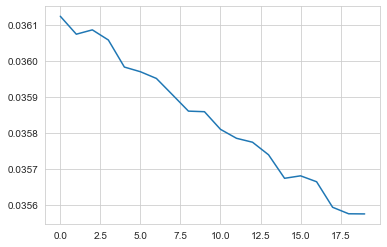

In [158]:
sns.lineplot(x=range(20), y=history.history['loss'][-20:])

In [159]:
preds = dl_model.predict(X_test)

In [162]:
mean_squared_error(np.array(y_test), preds)

1.1589975329246727

In [164]:
df = X.copy()

In [170]:
df.drop(index=df.index)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol


In [74]:
def return_model():
    dl_model = Sequential(
    [Dense(len(X.columns), activation='relu'),
    Dense(len(X.columns)//2, activation='relu'),
    Dense(1, activation='relu')])
    
    dl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return dl_model

In [79]:
bagged_X = []
bagged_y = []
np.random.seed(seed=seed)
for num_models in range(1,30):
    indexes = randint(low=0,high=len(X_bca)).rvs(len(X_bca))
    bagged_X.append(X_bca.iloc[indexes].copy())
    bagged_y.append(y.iloc[indexes].copy())

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [137]:
predictions = []
for i in range(len(bagged_X)):
    print(f"\n\n\n##################Model {i}##############\n\n\n\n\n\n")
    model = return_model()
    model.fit(bagged_X[i], bagged_y[i], epochs=10000, callbacks=[EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)], shuffle=True, verbose=0)
    preds = model.predict(X_test).flatten()
    while np.sum(preds) == 0:
        model = return_model()
        model.fit(bagged_X[i], bagged_y[i], epochs=10000, callbacks=[EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)], shuffle=True, verbose=0)
        preds = model.predict(X_test).flatten()
    predictions.append(model.predict(X_test).flatten())




##################Model 0##############







If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




##################Model 1##############







If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




##################Model 8##############







If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




##################Model 15##############







If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=Fals


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




##################Model 21##############







If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=Fals


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [138]:
predictions = np.array(predictions)

In [139]:
predictions

array([[5.6230164, 4.982223 , 6.499475 , ..., 6.060379 , 6.2250404,
        4.9596744],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [5.130064 , 4.74724  , 6.4337482, ..., 5.976223 , 5.900012 ,
        5.128468 ],
       ...,
       [6.8753767, 6.9994836, 4.992947 , ..., 8.774286 , 5.249694 ,
        5.900119 ],
       [6.4829936, 5.716317 , 5.889798 , ..., 6.6192985, 5.7972927,
        5.972399 ],
       [5.5484996, 5.246568 , 7.4840736, ..., 5.6602817, 5.5912514,
        4.956875 ]], dtype=float32)

In [140]:
aggregated_preds = list(map(lambda x: predictions[:,x][np.where(predictions[:,x]>0)].mean(), range(len(y_test))))

In [141]:
aggregated_preds

[5.787378,
 5.2542186,
 6.6254797,
 5.599549,
 5.698305,
 6.3077736,
 7.2707176,
 5.9476757,
 5.421916,
 5.275153,
 5.269885,
 5.459283,
 6.0767694,
 6.1608276,
 5.8190923,
 5.001167,
 5.5824213,
 6.0906196,
 5.8373604,
 4.922483,
 6.3848457,
 4.688381,
 5.627938,
 7.122714,
 4.933373,
 5.3639336,
 5.64051,
 5.518084,
 6.2147694,
 5.9674563,
 5.775976,
 5.556388,
 5.2884417,
 5.526138,
 5.3455653,
 5.934326,
 6.835706,
 5.559522,
 6.063583,
 6.705598,
 5.3714137,
 6.0352254,
 5.795515,
 6.3323517,
 6.954788,
 5.588518,
 4.900193,
 6.498125,
 5.9603796,
 5.7967076]

In [142]:
mean_squared_error(y_test, aggregated_preds)

0.6981877160737213

In [135]:
dl_model = Sequential(
    [Dense(len(X.columns), activation='relu'),
    Dense(len(X.columns)//2, activation='relu'),
    Dense(1, activation='relu')]
)
dl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = dl_model.fit(X_bca, y_bca, epochs=10000, callbacks=[EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)], shuffle=True, verbose=1)

Epoch 1/10000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 0s/step - loss: 174.5708 - mse: 174.5708
Epoch 2/10000
1/1 [==============================] - 0s 999us/step - loss: 162.0883 - mse: 162.0883
Epoch 3/10000
1/1 [==============================] - 0s 1ms/step - loss: 150.3039 - mse: 150.3039
Epoch 4/10000
1/1 [==============================] - 0s 995us/step - loss: 139.1140 - mse: 139.1140
Epoch 5/10000
1/1 [==============================] - 0s 2ms/step - loss: 128.5594 - mse: 128.5594
Epoch 6/10000
1

1/1 [==============================] - 0s 0s/step - loss: 12.9997 - mse: 12.9997
Epoch 79/10000
1/1 [==============================] - 0s 0s/step - loss: 12.8744 - mse: 12.8744
Epoch 80/10000
1/1 [==============================] - 0s 0s/step - loss: 12.7509 - mse: 12.7509
Epoch 81/10000
1/1 [==============================] - 0s 0s/step - loss: 12.6283 - mse: 12.6283
Epoch 82/10000
1/1 [==============================] - 0s 0s/step - loss: 12.5066 - mse: 12.5066
Epoch 83/10000
1/1 [==============================] - 0s 0s/step - loss: 12.3858 - mse: 12.3858
Epoch 84/10000
1/1 [==============================] - 0s 0s/step - loss: 12.2660 - mse: 12.2660
Epoch 85/10000
1/1 [==============================] - 0s 0s/step - loss: 12.1473 - mse: 12.1473
Epoch 86/10000
1/1 [==============================] - 0s 615us/step - loss: 12.0297 - mse: 12.0297
Epoch 87/10000
1/1 [==============================] - 0s 0s/step - loss: 11.9133 - mse: 11.9133
Epoch 88/10000
1/1 [==============================] 

1/1 [==============================] - 0s 0s/step - loss: 5.3745 - mse: 5.3745
Epoch 164/10000
1/1 [==============================] - 0s 0s/step - loss: 5.3129 - mse: 5.3129
Epoch 165/10000
1/1 [==============================] - 0s 509us/step - loss: 5.2523 - mse: 5.2523
Epoch 166/10000
1/1 [==============================] - 0s 0s/step - loss: 5.1924 - mse: 5.1924
Epoch 167/10000
1/1 [==============================] - 0s 0s/step - loss: 5.1334 - mse: 5.1334
Epoch 168/10000
1/1 [==============================] - 0s 995us/step - loss: 5.0752 - mse: 5.0752
Epoch 169/10000
1/1 [==============================] - 0s 1ms/step - loss: 5.0178 - mse: 5.0178
Epoch 170/10000
1/1 [==============================] - 0s 1ms/step - loss: 4.9612 - mse: 4.9612
Epoch 171/10000
1/1 [==============================] - 0s 999us/step - loss: 4.9054 - mse: 4.9054
Epoch 172/10000
1/1 [==============================] - 0s 0s/step - loss: 4.8504 - mse: 4.8504
Epoch 173/10000
1/1 [==============================] - 

1/1 [==============================] - 0s 0s/step - loss: 1.5064 - mse: 1.5064
Epoch 250/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4859 - mse: 1.4859
Epoch 251/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4658 - mse: 1.4658
Epoch 252/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4461 - mse: 1.4461
Epoch 253/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4268 - mse: 1.4268
Epoch 254/10000
1/1 [==============================] - 0s 0s/step - loss: 1.4080 - mse: 1.4080
Epoch 255/10000
1/1 [==============================] - 0s 0s/step - loss: 1.3896 - mse: 1.3896
Epoch 256/10000
1/1 [==============================] - 0s 0s/step - loss: 1.3717 - mse: 1.3717
Epoch 257/10000
1/1 [==============================] - 0s 0s/step - loss: 1.3549 - mse: 1.3549
Epoch 258/10000
1/1 [==============================] - 0s 16ms/step - loss: 1.3385 - mse: 1.3385
Epoch 259/10000
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.7701 - mse: 0.7701
Epoch 336/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7675 - mse: 0.7675
Epoch 337/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7650 - mse: 0.7650
Epoch 338/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7625 - mse: 0.7625
Epoch 339/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.7601 - mse: 0.7601
Epoch 340/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7577 - mse: 0.7577
Epoch 341/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.7554 - mse: 0.7554
Epoch 342/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7532 - mse: 0.7532
Epoch 343/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7509 - mse: 0.7509
Epoch 344/10000
1/1 [==============================] - 0s 0s/step - loss: 0.7488 - mse: 0.7488
Epoch 345/10000
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.6449 - mse: 0.6449
Epoch 422/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6438 - mse: 0.6438
Epoch 423/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6428 - mse: 0.6428
Epoch 424/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.6417 - mse: 0.6417
Epoch 425/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6407 - mse: 0.6407
Epoch 426/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6397 - mse: 0.6397
Epoch 427/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6388 - mse: 0.6388
Epoch 428/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6379 - mse: 0.6379
Epoch 429/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6369 - mse: 0.6369
Epoch 430/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6359 - mse: 0.6359
Epoch 431/10000
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.5816 - mse: 0.5816
Epoch 508/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.5812 - mse: 0.5812
Epoch 509/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5807 - mse: 0.5807
Epoch 510/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5803 - mse: 0.5803
Epoch 511/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5799 - mse: 0.5799
Epoch 512/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5795 - mse: 0.5795
Epoch 513/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5791 - mse: 0.5791
Epoch 514/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5787 - mse: 0.5787
Epoch 515/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5783 - mse: 0.5783
Epoch 516/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5779 - mse: 0.5779
Epoch 517/10000
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 8ms/step - loss: 0.5493 - mse: 0.5493
Epoch 594/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5490 - mse: 0.5490
Epoch 595/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5487 - mse: 0.5487
Epoch 596/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5483 - mse: 0.5483
Epoch 597/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5480 - mse: 0.5480
Epoch 598/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5476 - mse: 0.5476
Epoch 599/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5473 - mse: 0.5473
Epoch 600/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5469 - mse: 0.5469
Epoch 601/10000
1/1 [==============================] - 0s 806us/step - loss: 0.5466 - mse: 0.5466
Epoch 602/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5463 - mse: 0.5463
Epoch 603/10000
1/1 [==============================] - 0s 0s/

1/1 [==============================] - 0s 0s/step - loss: 0.5226 - mse: 0.5226
Epoch 680/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5223 - mse: 0.5223
Epoch 681/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5221 - mse: 0.5221
Epoch 682/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5218 - mse: 0.5218
Epoch 683/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5215 - mse: 0.5215
Epoch 684/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5212 - mse: 0.5212
Epoch 685/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5209 - mse: 0.5209
Epoch 686/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5207 - mse: 0.5207
Epoch 687/10000
1/1 [==============================] - 0s 654us/step - loss: 0.5204 - mse: 0.5204
Epoch 688/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5201 - mse: 0.5201
Epoch 689/10000
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 16ms/step - loss: 0.4998 - mse: 0.4998
Epoch 766/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4996 - mse: 0.4996
Epoch 767/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4993 - mse: 0.4993
Epoch 768/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4991 - mse: 0.4991
Epoch 769/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4988 - mse: 0.4988
Epoch 770/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4986 - mse: 0.4986
Epoch 771/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4983 - mse: 0.4983
Epoch 772/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4980 - mse: 0.4980
Epoch 773/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.4978 - mse: 0.4978
Epoch 774/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4975 - mse: 0.4975
Epoch 775/10000
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 0s/step - loss: 0.4785 - mse: 0.4785
Epoch 852/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.4783 - mse: 0.4783
Epoch 853/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4780 - mse: 0.4780
Epoch 854/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4778 - mse: 0.4778
Epoch 855/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4775 - mse: 0.4775
Epoch 856/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4773 - mse: 0.4773
Epoch 857/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4771 - mse: 0.4771
Epoch 858/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4768 - mse: 0.4768
Epoch 859/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4766 - mse: 0.4766
Epoch 860/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4763 - mse: 0.4763
Epoch 861/10000
1/1 [==============================] - 0s 0s/step

1/1 [==============================] - 0s 0s/step - loss: 0.4599 - mse: 0.4599
Epoch 938/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4597 - mse: 0.4597
Epoch 939/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4595 - mse: 0.4595
Epoch 940/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4593 - mse: 0.4593
Epoch 941/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4592 - mse: 0.4592
Epoch 942/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4590 - mse: 0.4590
Epoch 943/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4588 - mse: 0.4588
Epoch 944/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4586 - mse: 0.4586
Epoch 945/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4585 - mse: 0.4585
Epoch 946/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4583 - mse: 0.4583
Epoch 947/10000
1/1 [==============================] - 0s 0s/step 

1/1 [==============================] - 0s 0s/step - loss: 0.4455 - mse: 0.4455
Epoch 1023/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4453 - mse: 0.4453
Epoch 1024/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4451 - mse: 0.4451
Epoch 1025/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4450 - mse: 0.4450
Epoch 1026/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4448 - mse: 0.4448
Epoch 1027/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4447 - mse: 0.4447
Epoch 1028/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4445 - mse: 0.4445
Epoch 1029/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.4443 - mse: 0.4443
Epoch 1030/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4442 - mse: 0.4442
Epoch 1031/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4440 - mse: 0.4440
Epoch 1032/10000
1/1 [==============================] - 

1/1 [==============================] - 0s 0s/step - loss: 0.4319 - mse: 0.4319
Epoch 1107/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.4318 - mse: 0.4318
Epoch 1108/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4316 - mse: 0.4316
Epoch 1109/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4315 - mse: 0.4315
Epoch 1110/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4313 - mse: 0.4313
Epoch 1111/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4311 - mse: 0.4311
Epoch 1112/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4310 - mse: 0.4310
Epoch 1113/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4308 - mse: 0.4308
Epoch 1114/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4307 - mse: 0.4307
Epoch 1115/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4305 - mse: 0.4305
Epoch 1116/10000
1/1 [==============================] 

1/1 [==============================] - 0s 0s/step - loss: 0.4188 - mse: 0.4188
Epoch 1192/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4186 - mse: 0.4186
Epoch 1193/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4185 - mse: 0.4185
Epoch 1194/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4183 - mse: 0.4183
Epoch 1195/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4182 - mse: 0.4182
Epoch 1196/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4180 - mse: 0.4180
Epoch 1197/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4179 - mse: 0.4179
Epoch 1198/10000
1/1 [==============================] - ETA: 0s - loss: 0.4177 - mse: 0.417 - 0s 0s/step - loss: 0.4177 - mse: 0.4177
Epoch 1199/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4176 - mse: 0.4176
Epoch 1200/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4174 - mse: 0.4174
Epoch 1201/10000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.4063 - mse: 0.4063
Epoch 1276/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4061 - mse: 0.4061
Epoch 1277/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4060 - mse: 0.4060
Epoch 1278/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4058 - mse: 0.4058
Epoch 1279/10000
1/1 [==============================] - 0s 966us/step - loss: 0.4057 - mse: 0.4057
Epoch 1280/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4055 - mse: 0.4055
Epoch 1281/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4054 - mse: 0.4054
Epoch 1282/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4052 - mse: 0.4052
Epoch 1283/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4051 - mse: 0.4051
Epoch 1284/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4050 - mse: 0.4050
Epoch 1285/10000
1/1 [==============================] 

1/1 [==============================] - 0s 0s/step - loss: 0.3942 - mse: 0.3942
Epoch 1360/10000
1/1 [==============================] - 0s 976us/step - loss: 0.3940 - mse: 0.3940
Epoch 1361/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3939 - mse: 0.3939
Epoch 1362/10000
1/1 [==============================] - 0s 995us/step - loss: 0.3937 - mse: 0.3937
Epoch 1363/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3936 - mse: 0.3936
Epoch 1364/10000
1/1 [==============================] - 0s 999us/step - loss: 0.3935 - mse: 0.3935
Epoch 1365/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3933 - mse: 0.3933
Epoch 1366/10000
1/1 [==============================] - 0s 968us/step - loss: 0.3932 - mse: 0.3932
Epoch 1367/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3930 - mse: 0.3930
Epoch 1368/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3929 - mse: 0.3929
Epoch 1369/10000
1/1 [======================

1/1 [==============================] - 0s 0s/step - loss: 0.3824 - mse: 0.3824
Epoch 1444/10000
1/1 [==============================] - 0s 999us/step - loss: 0.3823 - mse: 0.3823
Epoch 1445/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3821 - mse: 0.3821
Epoch 1446/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3820 - mse: 0.3820
Epoch 1447/10000
1/1 [==============================] - 0s 816us/step - loss: 0.3819 - mse: 0.3819
Epoch 1448/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3817 - mse: 0.3817
Epoch 1449/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3816 - mse: 0.3816
Epoch 1450/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3815 - mse: 0.3815
Epoch 1451/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.3813 - mse: 0.3813
Epoch 1452/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3812 - mse: 0.3812
Epoch 1453/10000
1/1 [========================

1/1 [==============================] - 0s 0s/step - loss: 0.3710 - mse: 0.3710
Epoch 1528/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.3709 - mse: 0.3709
Epoch 1529/10000
1/1 [==============================] - 0s 995us/step - loss: 0.3707 - mse: 0.3707
Epoch 1530/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3706 - mse: 0.3706
Epoch 1531/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3705 - mse: 0.3705
Epoch 1532/10000
1/1 [==============================] - 0s 996us/step - loss: 0.3703 - mse: 0.3703
Epoch 1533/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3702 - mse: 0.3702
Epoch 1534/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3701 - mse: 0.3701
Epoch 1535/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.3700 - mse: 0.3700
Epoch 1536/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3698 - mse: 0.3698
Epoch 1537/10000
1/1 [=========================

1/1 [==============================] - 0s 999us/step - loss: 0.3599 - mse: 0.3599
Epoch 1612/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3598 - mse: 0.3598
Epoch 1613/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3597 - mse: 0.3597
Epoch 1614/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3596 - mse: 0.3596
Epoch 1615/10000
1/1 [==============================] - 0s 999us/step - loss: 0.3594 - mse: 0.3594
Epoch 1616/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3593 - mse: 0.3593
Epoch 1617/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3592 - mse: 0.3592
Epoch 1618/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3591 - mse: 0.3591
Epoch 1619/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3589 - mse: 0.3589
Epoch 1620/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3588 - mse: 0.3588
Epoch 1621/10000
1/1 [==========================

1/1 [==============================] - 0s 0s/step - loss: 0.3492 - mse: 0.3492
Epoch 1696/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3491 - mse: 0.3491
Epoch 1697/10000
1/1 [==============================] - 0s 998us/step - loss: 0.3490 - mse: 0.3490
Epoch 1698/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3489 - mse: 0.3489
Epoch 1699/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3487 - mse: 0.3487
Epoch 1700/10000
1/1 [==============================] - 0s 963us/step - loss: 0.3486 - mse: 0.3486
Epoch 1701/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3485 - mse: 0.3485
Epoch 1702/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3484 - mse: 0.3484
Epoch 1703/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.3482 - mse: 0.3482
Epoch 1704/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3481 - mse: 0.3481
Epoch 1705/10000
1/1 [=========================

1/1 [==============================] - 0s 1ms/step - loss: 0.3384 - mse: 0.3384
Epoch 1780/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3382 - mse: 0.3382
Epoch 1781/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3380 - mse: 0.3380
Epoch 1782/10000
1/1 [==============================] - 0s 997us/step - loss: 0.3377 - mse: 0.3377
Epoch 1783/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3375 - mse: 0.3375
Epoch 1784/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3373 - mse: 0.3373
Epoch 1785/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3370 - mse: 0.3370
Epoch 1786/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3368 - mse: 0.3368
Epoch 1787/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3365 - mse: 0.3365
Epoch 1788/10000
1/1 [==============================] - 0s 997us/step - loss: 0.3363 - mse: 0.3363
Epoch 1789/10000
1/1 [===========================

1/1 [==============================] - 0s 0s/step - loss: 0.3250 - mse: 0.3250
Epoch 1864/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3249 - mse: 0.3249
Epoch 1865/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3248 - mse: 0.3248
Epoch 1866/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3246 - mse: 0.3246
Epoch 1867/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3245 - mse: 0.3245
Epoch 1868/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.3244 - mse: 0.3244
Epoch 1869/10000
1/1 [==============================] - 0s 998us/step - loss: 0.3243 - mse: 0.3243
Epoch 1870/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3241 - mse: 0.3241
Epoch 1871/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3240 - mse: 0.3240
Epoch 1872/10000
1/1 [==============================] - 0s 992us/step - loss: 0.3239 - mse: 0.3239
Epoch 1873/10000
1/1 [==========================

1/1 [==============================] - 0s 2ms/step - loss: 0.3170 - mse: 0.3170
Epoch 1948/10000
1/1 [==============================] - 0s 999us/step - loss: 0.3169 - mse: 0.3169
Epoch 1949/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3168 - mse: 0.3168
Epoch 1950/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.3168 - mse: 0.3168
Epoch 1951/10000
1/1 [==============================] - 0s 998us/step - loss: 0.3167 - mse: 0.3167
Epoch 1952/10000
1/1 [==============================] - 0s 910us/step - loss: 0.3166 - mse: 0.3166
Epoch 1953/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3165 - mse: 0.3165
Epoch 1954/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3165 - mse: 0.3165
Epoch 1955/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3164 - mse: 0.3164
Epoch 1956/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3163 - mse: 0.3163
Epoch 1957/10000
1/1 [======================

1/1 [==============================] - 0s 0s/step - loss: 0.3111 - mse: 0.3111
Epoch 2032/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3110 - mse: 0.3110
Epoch 2033/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3109 - mse: 0.3109
Epoch 2034/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.3109 - mse: 0.3109
Epoch 2035/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2036/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3107 - mse: 0.3107
Epoch 2037/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3107 - mse: 0.3107
Epoch 2038/10000
1/1 [==============================] - 0s 997us/step - loss: 0.3106 - mse: 0.3106
Epoch 2039/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3106 - mse: 0.3106
Epoch 2040/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3105 - mse: 0.3105
Epoch 2041/10000
1/1 [===========================

1/1 [==============================] - 0s 0s/step - loss: 0.3059 - mse: 0.3059
Epoch 2116/10000
1/1 [==============================] - 0s 976us/step - loss: 0.3058 - mse: 0.3058
Epoch 2117/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3058 - mse: 0.3058
Epoch 2118/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3057 - mse: 0.3057
Epoch 2119/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3056 - mse: 0.3056
Epoch 2120/10000
1/1 [==============================] - 0s 994us/step - loss: 0.3056 - mse: 0.3056
Epoch 2121/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3055 - mse: 0.3055
Epoch 2122/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3055 - mse: 0.3055
Epoch 2123/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3054 - mse: 0.3054
Epoch 2124/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3053 - mse: 0.3053
Epoch 2125/10000
1/1 [==========================

1/1 [==============================] - 0s 1ms/step - loss: 0.3011 - mse: 0.3011
Epoch 2200/10000
1/1 [==============================] - 0s 999us/step - loss: 0.3010 - mse: 0.3010
Epoch 2201/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3009 - mse: 0.3009
Epoch 2202/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3009 - mse: 0.3009
Epoch 2203/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3008 - mse: 0.3008
Epoch 2204/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3008 - mse: 0.3008
Epoch 2205/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3007 - mse: 0.3007
Epoch 2206/10000
1/1 [==============================] - 0s 998us/step - loss: 0.3007 - mse: 0.3007
Epoch 2207/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3006 - mse: 0.3006
Epoch 2208/10000
1/1 [==============================] - 0s 0s/step - loss: 0.3006 - mse: 0.3006
Epoch 2209/10000
1/1 [========================

1/1 [==============================] - 0s 1ms/step - loss: 0.2965 - mse: 0.2965
Epoch 2284/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2965 - mse: 0.2965
Epoch 2285/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2964 - mse: 0.2964
Epoch 2286/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2963 - mse: 0.2963
Epoch 2287/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2963 - mse: 0.2963
Epoch 2288/10000
1/1 [==============================] - 0s 926us/step - loss: 0.2962 - mse: 0.2962
Epoch 2289/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2962 - mse: 0.2962
Epoch 2290/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2961 - mse: 0.2961
Epoch 2291/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2961 - mse: 0.2961
Epoch 2292/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2960 - mse: 0.2960
Epoch 2293/10000
1/1 [=============================

1/1 [==============================] - 0s 999us/step - loss: 0.2922 - mse: 0.2922
Epoch 2368/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2921 - mse: 0.2921
Epoch 2369/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2921 - mse: 0.2921
Epoch 2370/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.2920 - mse: 0.2920
Epoch 2371/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2920 - mse: 0.2920
Epoch 2372/10000
1/1 [==============================] - 0s 998us/step - loss: 0.2919 - mse: 0.2919
Epoch 2373/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2919 - mse: 0.2919
Epoch 2374/10000
1/1 [==============================] - 0s 997us/step - loss: 0.2918 - mse: 0.2918
Epoch 2375/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2918 - mse: 0.2918
Epoch 2376/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2917 - mse: 0.2917
Epoch 2377/10000
1/1 [=======================

1/1 [==============================] - 0s 998us/step - loss: 0.2880 - mse: 0.2880
Epoch 2452/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2879 - mse: 0.2879
Epoch 2453/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2879 - mse: 0.2879
Epoch 2454/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.2878 - mse: 0.2878
Epoch 2455/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2878 - mse: 0.2878
Epoch 2456/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2877 - mse: 0.2877
Epoch 2457/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2877 - mse: 0.2877
Epoch 2458/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2876 - mse: 0.2876
Epoch 2459/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2876 - mse: 0.2876
Epoch 2460/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2875 - mse: 0.2875
Epoch 2461/10000
1/1 [==========================

1/1 [==============================] - 0s 999us/step - loss: 0.2840 - mse: 0.2840
Epoch 2536/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2839 - mse: 0.2839
Epoch 2537/10000
1/1 [==============================] - ETA: 0s - loss: 0.2839 - mse: 0.283 - 0s 0s/step - loss: 0.2839 - mse: 0.2839
Epoch 2538/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2838 - mse: 0.2838
Epoch 2539/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2838 - mse: 0.2838
Epoch 2540/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2837 - mse: 0.2837
Epoch 2541/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2837 - mse: 0.2837
Epoch 2542/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2836 - mse: 0.2836
Epoch 2543/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2836 - mse: 0.2836
Epoch 2544/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2836 - mse: 0.2836
Epoch 2545/

1/1 [==============================] - 0s 986us/step - loss: 0.2798 - mse: 0.2798
Epoch 2620/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2798 - mse: 0.2798
Epoch 2621/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2797 - mse: 0.2797
Epoch 2622/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2797 - mse: 0.2797
Epoch 2623/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2797 - mse: 0.2797
Epoch 2624/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2796 - mse: 0.2796
Epoch 2625/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2796 - mse: 0.2796
Epoch 2626/10000
1/1 [==============================] - 0s 135us/step - loss: 0.2796 - mse: 0.2796
Epoch 2627/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2795 - mse: 0.2795
Epoch 2628/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2795 - mse: 0.2795
Epoch 2629/10000
1/1 [========================

1/1 [==============================] - 0s 0s/step - loss: 0.2770 - mse: 0.2770
Epoch 2704/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2769 - mse: 0.2769
Epoch 2705/10000
1/1 [==============================] - 0s 998us/step - loss: 0.2769 - mse: 0.2769
Epoch 2706/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2769 - mse: 0.2769
Epoch 2707/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2768 - mse: 0.2768
Epoch 2708/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2768 - mse: 0.2768
Epoch 2709/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2768 - mse: 0.2768
Epoch 2710/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2767 - mse: 0.2767
Epoch 2711/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2767 - mse: 0.2767
Epoch 2712/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2767 - mse: 0.2767
Epoch 2713/10000
1/1 [==============================

1/1 [==============================] - 0s 0s/step - loss: 0.2743 - mse: 0.2743
Epoch 2788/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.2743 - mse: 0.2743
Epoch 2789/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2743 - mse: 0.2743
Epoch 2790/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2742 - mse: 0.2742
Epoch 2791/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2742 - mse: 0.2742
Epoch 2792/10000
1/1 [==============================] - 0s 998us/step - loss: 0.2742 - mse: 0.2742
Epoch 2793/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2741 - mse: 0.2741
Epoch 2794/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2741 - mse: 0.2741
Epoch 2795/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2741 - mse: 0.2741
Epoch 2796/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2740 - mse: 0.2740
Epoch 2797/10000
1/1 [======================

1/1 [==============================] - 0s 989us/step - loss: 0.2718 - mse: 0.2718
Epoch 2872/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2718 - mse: 0.2718
Epoch 2873/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2717 - mse: 0.2717
Epoch 2874/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2717 - mse: 0.2717
Epoch 2875/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2717 - mse: 0.2717
Epoch 2876/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2716 - mse: 0.2716
Epoch 2877/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2716 - mse: 0.2716
Epoch 2878/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2716 - mse: 0.2716
Epoch 2879/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2716 - mse: 0.2716
Epoch 2880/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2715 - mse: 0.2715
Epoch 2881/10000
1/1 [=============================

1/1 [==============================] - 0s 0s/step - loss: 0.2694 - mse: 0.2694
Epoch 2956/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2693 - mse: 0.2693
Epoch 2957/10000
1/1 [==============================] - 0s 746us/step - loss: 0.2693 - mse: 0.2693
Epoch 2958/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.2693 - mse: 0.2693
Epoch 2959/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2692 - mse: 0.2692
Epoch 2960/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2692 - mse: 0.2692
Epoch 2961/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2692 - mse: 0.2692
Epoch 2962/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2692 - mse: 0.2692
Epoch 2963/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.2691 - mse: 0.2691
Epoch 2964/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2691 - mse: 0.2691
Epoch 2965/10000
1/1 [====================

1/1 [==============================] - 0s 997us/step - loss: 0.2670 - mse: 0.2670
Epoch 3040/10000
1/1 [==============================] - 0s 992us/step - loss: 0.2670 - mse: 0.2670
Epoch 3041/10000
1/1 [==============================] - 0s 998us/step - loss: 0.2669 - mse: 0.2669
Epoch 3042/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2669 - mse: 0.2669
Epoch 3043/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2669 - mse: 0.2669
Epoch 3044/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2669 - mse: 0.2669
Epoch 3045/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2668 - mse: 0.2668
Epoch 3046/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2668 - mse: 0.2668
Epoch 3047/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2668 - mse: 0.2668
Epoch 3048/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2668 - mse: 0.2668
Epoch 3049/10000
1/1 [======================

1/1 [==============================] - 0s 0s/step - loss: 0.2647 - mse: 0.2647
Epoch 3124/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2647 - mse: 0.2647
Epoch 3125/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2647 - mse: 0.2647
Epoch 3126/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2646 - mse: 0.2646
Epoch 3127/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2646 - mse: 0.2646
Epoch 3128/10000
1/1 [==============================] - 0s 988us/step - loss: 0.2646 - mse: 0.2646
Epoch 3129/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2646 - mse: 0.2646
Epoch 3130/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2645 - mse: 0.2645
Epoch 3131/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2645 - mse: 0.2645
Epoch 3132/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2645 - mse: 0.2645
Epoch 3133/10000
1/1 [============================

1/1 [==============================] - 0s 999us/step - loss: 0.2625 - mse: 0.2625
Epoch 3208/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2625 - mse: 0.2625
Epoch 3209/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2624 - mse: 0.2624
Epoch 3210/10000
1/1 [==============================] - 0s 974us/step - loss: 0.2624 - mse: 0.2624
Epoch 3211/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2624 - mse: 0.2624
Epoch 3212/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2624 - mse: 0.2624
Epoch 3213/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2623 - mse: 0.2623
Epoch 3214/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2623 - mse: 0.2623
Epoch 3215/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2623 - mse: 0.2623
Epoch 3216/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2623 - mse: 0.2623
Epoch 3217/10000
1/1 [=========================

1/1 [==============================] - 0s 0s/step - loss: 0.2603 - mse: 0.2603
Epoch 3292/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2603 - mse: 0.2603
Epoch 3293/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2603 - mse: 0.2603
Epoch 3294/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2603 - mse: 0.2603
Epoch 3295/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2602 - mse: 0.2602
Epoch 3296/10000
1/1 [==============================] - 0s 998us/step - loss: 0.2602 - mse: 0.2602
Epoch 3297/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2602 - mse: 0.2602
Epoch 3298/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2602 - mse: 0.2602
Epoch 3299/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.2601 - mse: 0.2601
Epoch 3300/10000
1/1 [==============================] - 0s 997us/step - loss: 0.2601 - mse: 0.2601
Epoch 3301/10000
1/1 [========================

1/1 [==============================] - 0s 994us/step - loss: 0.2582 - mse: 0.2582
Epoch 3376/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2582 - mse: 0.2582
Epoch 3377/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2582 - mse: 0.2582
Epoch 3378/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2582 - mse: 0.2582
Epoch 3379/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2581 - mse: 0.2581
Epoch 3380/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2581 - mse: 0.2581
Epoch 3381/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2581 - mse: 0.2581
Epoch 3382/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2581 - mse: 0.2581
Epoch 3383/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2580 - mse: 0.2580
Epoch 3384/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2580 - mse: 0.2580
Epoch 3385/10000
1/1 [===========================

1/1 [==============================] - 0s 741us/step - loss: 0.2562 - mse: 0.2562
Epoch 3460/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2562 - mse: 0.2562
Epoch 3461/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2561 - mse: 0.2561
Epoch 3462/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2561 - mse: 0.2561
Epoch 3463/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2561 - mse: 0.2561
Epoch 3464/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2561 - mse: 0.2561
Epoch 3465/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2560 - mse: 0.2560
Epoch 3466/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2560 - mse: 0.2560
Epoch 3467/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2560 - mse: 0.2560
Epoch 3468/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2560 - mse: 0.2560
Epoch 3469/10000
1/1 [============================

1/1 [==============================] - 0s 1ms/step - loss: 0.2542 - mse: 0.2542
Epoch 3544/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2542 - mse: 0.2542
Epoch 3545/10000
1/1 [==============================] - 0s 985us/step - loss: 0.2541 - mse: 0.2541
Epoch 3546/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2541 - mse: 0.2541
Epoch 3547/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2541 - mse: 0.2541
Epoch 3548/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2541 - mse: 0.2541
Epoch 3549/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2540 - mse: 0.2540
Epoch 3550/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2540 - mse: 0.2540
Epoch 3551/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2540 - mse: 0.2540
Epoch 3552/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2540 - mse: 0.2540
Epoch 3553/10000
1/1 [======================

1/1 [==============================] - 0s 997us/step - loss: 0.2522 - mse: 0.2522
Epoch 3628/10000
1/1 [==============================] - 0s 947us/step - loss: 0.2522 - mse: 0.2522
Epoch 3629/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2522 - mse: 0.2522
Epoch 3630/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2522 - mse: 0.2522
Epoch 3631/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.2522 - mse: 0.2522
Epoch 3632/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.2521 - mse: 0.2521
Epoch 3633/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2521 - mse: 0.2521
Epoch 3634/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2521 - mse: 0.2521
Epoch 3635/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.2521 - mse: 0.2521
Epoch 3636/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2520 - mse: 0.2520
Epoch 3637/10000
1/1 [===================

1/1 [==============================] - 0s 994us/step - loss: 0.2504 - mse: 0.2504
Epoch 3712/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2504 - mse: 0.2504
Epoch 3713/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2503 - mse: 0.2503
Epoch 3714/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2503 - mse: 0.2503
Epoch 3715/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2503 - mse: 0.2503
Epoch 3716/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2503 - mse: 0.2503
Epoch 3717/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2502 - mse: 0.2502
Epoch 3718/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2502 - mse: 0.2502
Epoch 3719/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2502 - mse: 0.2502
Epoch 3720/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.2502 - mse: 0.2502
Epoch 3721/10000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.2486 - mse: 0.2486
Epoch 3796/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2485 - mse: 0.2485
Epoch 3797/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2485 - mse: 0.2485
Epoch 3798/10000
1/1 [==============================] - 0s 997us/step - loss: 0.2485 - mse: 0.2485
Epoch 3799/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2485 - mse: 0.2485
Epoch 3800/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2485 - mse: 0.2485
Epoch 3801/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2484 - mse: 0.2484
Epoch 3802/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2484 - mse: 0.2484
Epoch 3803/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2484 - mse: 0.2484
Epoch 3804/10000
1/1 [==============================] - 0s 587us/step - loss: 0.2484 - mse: 0.2484
Epoch 3805/10000
1/1 [=====================

1/1 [==============================] - 0s 1000us/step - loss: 0.2468 - mse: 0.2468
Epoch 3880/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2468 - mse: 0.2468
Epoch 3881/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2468 - mse: 0.2468
Epoch 3882/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2468 - mse: 0.2468
Epoch 3883/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2467 - mse: 0.2467
Epoch 3884/10000
1/1 [==============================] - 0s 996us/step - loss: 0.2467 - mse: 0.2467
Epoch 3885/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2467 - mse: 0.2467
Epoch 3886/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2467 - mse: 0.2467
Epoch 3887/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2467 - mse: 0.2467
Epoch 3888/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2466 - mse: 0.2466
Epoch 3889/10000
1/1 [======================

In [136]:
mean_squared_error(y_test, dl_model.predict(X_test))

0.8765437011902861

In [144]:
dl_model = Sequential(
    [Dense(len(X.columns), activation='relu'),
    Dense(len(X.columns)//2, activation='relu'),
    Dense(1, activation='relu')]
)
dl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = dl_model.fit(X_dropped, y_dropped, epochs=10000, callbacks=[EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)], shuffle=True, verbose=1)

Epoch 1/10000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 0s/step - loss: 20.8025 - mse: 20.8025
Epoch 2/10000
1/1 [==============================] - 0s 2ms/step - loss: 20.1793 - mse: 20.1793
Epoch 3/10000
1/1 [==============================] - 0s 3ms/step - loss: 19.5818 - mse: 19.5818
Epoch 4/10000
1/1 [==============================] - 0s 3ms/step - loss: 18.9848 - mse: 18.9848
Epoch 5/10000
1/1 [==============================] - 0s 3ms/step - loss: 18.1702 - mse: 18.1702
Epoch 6/10000
1/1 [==========

1/1 [==============================] - 0s 4ms/step - loss: 3.8282 - mse: 3.8282
Epoch 80/10000
1/1 [==============================] - 0s 6ms/step - loss: 3.7766 - mse: 3.7766
Epoch 81/10000
1/1 [==============================] - 0s 7ms/step - loss: 3.7252 - mse: 3.7252
Epoch 82/10000
1/1 [==============================] - 0s 3ms/step - loss: 3.6774 - mse: 3.6774
Epoch 83/10000
1/1 [==============================] - 0s 3ms/step - loss: 3.6342 - mse: 3.6342
Epoch 84/10000
1/1 [==============================] - 0s 3ms/step - loss: 3.5911 - mse: 3.5911
Epoch 85/10000
1/1 [==============================] - 0s 5ms/step - loss: 3.5509 - mse: 3.5509
Epoch 86/10000
1/1 [==============================] - 0s 5ms/step - loss: 3.5108 - mse: 3.5108
Epoch 87/10000
1/1 [==============================] - 0s 4ms/step - loss: 3.4703 - mse: 3.4703
Epoch 88/10000
1/1 [==============================] - 0s 3ms/step - loss: 3.4295 - mse: 3.4295
Epoch 89/10000
1/1 [==============================] - 0s 3ms/step

1/1 [==============================] - 0s 1ms/step - loss: 1.2972 - mse: 1.2972
Epoch 165/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2825 - mse: 1.2825
Epoch 166/10000
1/1 [==============================] - 0s 1ms/step - loss: 1.2682 - mse: 1.2682
Epoch 167/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.2547 - mse: 1.2547
Epoch 168/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.2414 - mse: 1.2414
Epoch 169/10000
1/1 [==============================] - 0s 997us/step - loss: 1.2283 - mse: 1.2283
Epoch 170/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.2155 - mse: 1.2155
Epoch 171/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2028 - mse: 1.2028
Epoch 172/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1904 - mse: 1.1904
Epoch 173/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.1783 - mse: 1.1783
Epoch 174/10000
1/1 [==============================] -

1/1 [==============================] - 0s 9ms/step - loss: 0.7317 - mse: 0.7317
Epoch 250/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.7299 - mse: 0.7299
Epoch 251/10000
1/1 [==============================] - 0s 996us/step - loss: 0.7280 - mse: 0.7280
Epoch 252/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.7262 - mse: 0.7262
Epoch 253/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.7244 - mse: 0.7244
Epoch 254/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.7227 - mse: 0.7227
Epoch 255/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.7210 - mse: 0.7210
Epoch 256/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.7193 - mse: 0.7193
Epoch 257/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.7177 - mse: 0.7177
Epoch 258/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.7161 - mse: 0.7161
Epoch 259/10000
1/1 [==============================] -

1/1 [==============================] - 0s 2ms/step - loss: 0.6377 - mse: 0.6377
Epoch 335/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.6370 - mse: 0.6370
Epoch 336/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6361 - mse: 0.6361
Epoch 337/10000
1/1 [==============================] - 0s 988us/step - loss: 0.6353 - mse: 0.6353
Epoch 338/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6345 - mse: 0.6345
Epoch 339/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.6337 - mse: 0.6337
Epoch 340/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.6330 - mse: 0.6330
Epoch 341/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.6321 - mse: 0.6321
Epoch 342/10000
1/1 [==============================] - 0s 0s/step - loss: 0.6314 - mse: 0.6314
Epoch 343/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.6306 - mse: 0.6306
Epoch 344/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 3ms/step - loss: 0.5768 - mse: 0.5768
Epoch 420/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5762 - mse: 0.5762
Epoch 421/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.5755 - mse: 0.5755
Epoch 422/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5749 - mse: 0.5749
Epoch 423/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5743 - mse: 0.5743
Epoch 424/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.5736 - mse: 0.5736
Epoch 425/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5730 - mse: 0.5730
Epoch 426/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5724 - mse: 0.5724
Epoch 427/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.5717 - mse: 0.5717
Epoch 428/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.5711 - mse: 0.5711
Epoch 429/10000
1/1 [==============================] - 

1/1 [==============================] - 0s 4ms/step - loss: 0.5245 - mse: 0.5245
Epoch 505/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.5238 - mse: 0.5238
Epoch 506/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5233 - mse: 0.5233
Epoch 507/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5227 - mse: 0.5227
Epoch 508/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5221 - mse: 0.5221
Epoch 509/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.5215 - mse: 0.5215
Epoch 510/10000
1/1 [==============================] - 0s 0s/step - loss: 0.5209 - mse: 0.5209
Epoch 511/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.5204 - mse: 0.5204
Epoch 512/10000
1/1 [==============================] - 0s 999us/step - loss: 0.5198 - mse: 0.5198
Epoch 513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5192 - mse: 0.5192
Epoch 514/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 7ms/step - loss: 0.4781 - mse: 0.4781
Epoch 590/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4776 - mse: 0.4776
Epoch 591/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4771 - mse: 0.4771
Epoch 592/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4766 - mse: 0.4766
Epoch 593/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.4760 - mse: 0.4760
Epoch 594/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4755 - mse: 0.4755
Epoch 595/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4750 - mse: 0.4750
Epoch 596/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4745 - mse: 0.4745
Epoch 597/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4740 - mse: 0.4740
Epoch 598/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4735 - mse: 0.4735
Epoch 599/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 4ms/step - loss: 0.4369 - mse: 0.4369
Epoch 675/10000
1/1 [==============================] - 0s 0s/step - loss: 0.4364 - mse: 0.4364
Epoch 676/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.4359 - mse: 0.4359
Epoch 677/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4355 - mse: 0.4355
Epoch 678/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.4351 - mse: 0.4351
Epoch 679/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4346 - mse: 0.4346
Epoch 680/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4341 - mse: 0.4341
Epoch 681/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4337 - mse: 0.4337
Epoch 682/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4332 - mse: 0.4332
Epoch 683/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.4328 - mse: 0.4328
Epoch 684/10000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 3ms/step - loss: 0.3997 - mse: 0.3997
Epoch 760/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3993 - mse: 0.3993
Epoch 761/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3988 - mse: 0.3988
Epoch 762/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3984 - mse: 0.3984
Epoch 763/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3980 - mse: 0.3980
Epoch 764/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3976 - mse: 0.3976
Epoch 765/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3971 - mse: 0.3971
Epoch 766/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3967 - mse: 0.3967
Epoch 767/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.3963 - mse: 0.3963
Epoch 768/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3959 - mse: 0.3959
Epoch 769/10000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.3655 - mse: 0.3655
Epoch 845/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3651 - mse: 0.3651
Epoch 846/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3647 - mse: 0.3647
Epoch 847/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3643 - mse: 0.3643
Epoch 848/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3639 - mse: 0.3639
Epoch 849/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3635 - mse: 0.3635
Epoch 850/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3631 - mse: 0.3631
Epoch 851/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3628 - mse: 0.3628
Epoch 852/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3624 - mse: 0.3624
Epoch 853/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3620 - mse: 0.3620
Epoch 854/10000
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.3337 - mse: 0.3337
Epoch 930/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3333 - mse: 0.3333
Epoch 931/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.3329 - mse: 0.3329
Epoch 932/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3326 - mse: 0.3326
Epoch 933/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3322 - mse: 0.3322
Epoch 934/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3318 - mse: 0.3318
Epoch 935/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.3315 - mse: 0.3315
Epoch 936/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3311 - mse: 0.3311
Epoch 937/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3307 - mse: 0.3307
Epoch 938/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3304 - mse: 0.3304
Epoch 939/10000
1/1 [==============================] - 0

1/1 [==============================] - 0s 4ms/step - loss: 0.3057 - mse: 0.3057
Epoch 1015/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3054 - mse: 0.3054
Epoch 1016/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3051 - mse: 0.3051
Epoch 1017/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3047 - mse: 0.3047
Epoch 1018/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3044 - mse: 0.3044
Epoch 1019/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3041 - mse: 0.3041
Epoch 1020/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3038 - mse: 0.3038
Epoch 1021/10000
1/1 [==============================] - 0s 996us/step - loss: 0.3035 - mse: 0.3035
Epoch 1022/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3032 - mse: 0.3032
Epoch 1023/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3029 - mse: 0.3029
Epoch 1024/10000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.2796 - mse: 0.2796
Epoch 1099/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2793 - mse: 0.2793
Epoch 1100/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2790 - mse: 0.2790
Epoch 1101/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2787 - mse: 0.2787
Epoch 1102/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2784 - mse: 0.2784
Epoch 1103/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2781 - mse: 0.2781
Epoch 1104/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2778 - mse: 0.2778
Epoch 1105/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2774 - mse: 0.2774
Epoch 1106/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2772 - mse: 0.2772
Epoch 1107/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2769 - mse: 0.2769
Epoch 1108/10000
1/1 [==========================

1/1 [==============================] - 0s 3ms/step - loss: 0.2546 - mse: 0.2546
Epoch 1183/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2544 - mse: 0.2544
Epoch 1184/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2541 - mse: 0.2541
Epoch 1185/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2538 - mse: 0.2538
Epoch 1186/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2534 - mse: 0.2534
Epoch 1187/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2531 - mse: 0.2531
Epoch 1188/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2529 - mse: 0.2529
Epoch 1189/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2525 - mse: 0.2525
Epoch 1190/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2523 - mse: 0.2523
Epoch 1191/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2520 - mse: 0.2520
Epoch 1192/10000
1/1 [=========================

1/1 [==============================] - 0s 1ms/step - loss: 0.2309 - mse: 0.2309
Epoch 1267/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2307 - mse: 0.2307
Epoch 1268/10000
1/1 [==============================] - 0s 999us/step - loss: 0.2304 - mse: 0.2304
Epoch 1269/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2302 - mse: 0.2302
Epoch 1270/10000
1/1 [==============================] - 0s 991us/step - loss: 0.2298 - mse: 0.2298
Epoch 1271/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2295 - mse: 0.2295
Epoch 1272/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2294 - mse: 0.2294
Epoch 1273/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.2291 - mse: 0.2291
Epoch 1274/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2288 - mse: 0.2288
Epoch 1275/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2284 - mse: 0.2284
Epoch 1276/10000
1/1 [======================

1/1 [==============================] - 0s 0s/step - loss: 0.2081 - mse: 0.2081
Epoch 1351/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2078 - mse: 0.2078
Epoch 1352/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2075 - mse: 0.2075
Epoch 1353/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2072 - mse: 0.2072
Epoch 1354/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2069 - mse: 0.2069
Epoch 1355/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.2067 - mse: 0.2067
Epoch 1356/10000
1/1 [==============================] - 0s 988us/step - loss: 0.2064 - mse: 0.2064
Epoch 1357/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2061 - mse: 0.2061
Epoch 1358/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2058 - mse: 0.2058
Epoch 1359/10000
1/1 [==============================] - 0s 0s/step - loss: 0.2056 - mse: 0.2056
Epoch 1360/10000
1/1 [=========================

1/1 [==============================] - 0s 6ms/step - loss: 0.1857 - mse: 0.1857
Epoch 1435/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1855 - mse: 0.1855
Epoch 1436/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1852 - mse: 0.1852
Epoch 1437/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1850 - mse: 0.1850
Epoch 1438/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1846 - mse: 0.1846
Epoch 1439/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1844 - mse: 0.1844
Epoch 1440/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1842 - mse: 0.1842
Epoch 1441/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1839 - mse: 0.1839
Epoch 1442/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1836 - mse: 0.1836
Epoch 1443/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.1834 - mse: 0.1834
Epoch 1444/10000
1/1 [===========================

1/1 [==============================] - 0s 1000us/step - loss: 0.1642 - mse: 0.1642
Epoch 1519/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1639 - mse: 0.1639
Epoch 1520/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1636 - mse: 0.1636
Epoch 1521/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1634 - mse: 0.1634
Epoch 1522/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1632 - mse: 0.1632
Epoch 1523/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1629 - mse: 0.1629
Epoch 1524/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1627 - mse: 0.1627
Epoch 1525/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1624 - mse: 0.1624
Epoch 1526/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1621 - mse: 0.1621
Epoch 1527/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1619 - mse: 0.1619
Epoch 1528/10000
1/1 [========================

1/1 [==============================] - 0s 3ms/step - loss: 0.1439 - mse: 0.1439
Epoch 1603/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1436 - mse: 0.1436
Epoch 1604/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1434 - mse: 0.1434
Epoch 1605/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1432 - mse: 0.1432
Epoch 1606/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1430 - mse: 0.1430
Epoch 1607/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1427 - mse: 0.1427
Epoch 1608/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1424 - mse: 0.1424
Epoch 1609/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1423 - mse: 0.1423
Epoch 1610/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.1421 - mse: 0.1421
Epoch 1611/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1418 - mse: 0.1418
Epoch 1612/10000
1/1 [===========================

1/1 [==============================] - 0s 2ms/step - loss: 0.1247 - mse: 0.1247
Epoch 1687/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1245 - mse: 0.1245
Epoch 1688/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1242 - mse: 0.1242
Epoch 1689/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1240 - mse: 0.1240
Epoch 1690/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1237 - mse: 0.1237
Epoch 1691/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.1235 - mse: 0.1235
Epoch 1692/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1233 - mse: 0.1233
Epoch 1693/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1231 - mse: 0.1231
Epoch 1694/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1228 - mse: 0.1228
Epoch 1695/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1225 - mse: 0.1225
Epoch 1696/10000
1/1 [==========================

1/1 [==============================] - 0s 5ms/step - loss: 0.1064 - mse: 0.1064
Epoch 1771/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1062 - mse: 0.1062
Epoch 1772/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1060 - mse: 0.1060
Epoch 1773/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.1058 - mse: 0.1058
Epoch 1774/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1056 - mse: 0.1056
Epoch 1775/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1054 - mse: 0.1054
Epoch 1776/10000
1/1 [==============================] - 0s 0s/step - loss: 0.1052 - mse: 0.1052
Epoch 1777/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.1050 - mse: 0.1050
Epoch 1778/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1048 - mse: 0.1048
Epoch 1779/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.1046 - mse: 0.1046
Epoch 1780/10000
1/1 [==========================

1/1 [==============================] - 0s 2ms/step - loss: 0.0905 - mse: 0.0905
Epoch 1855/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0903 - mse: 0.0903
Epoch 1856/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0901 - mse: 0.0901
Epoch 1857/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0900 - mse: 0.0900
Epoch 1858/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0898 - mse: 0.0898
Epoch 1859/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0896 - mse: 0.0896
Epoch 1860/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0894 - mse: 0.0894
Epoch 1861/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0893 - mse: 0.0893
Epoch 1862/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0891 - mse: 0.0891
Epoch 1863/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.0889 - mse: 0.0889
Epoch 1864/10000
1/1 [========================

1/1 [==============================] - 0s 2ms/step - loss: 0.0762 - mse: 0.0762
Epoch 1939/10000
1/1 [==============================] - 0s 955us/step - loss: 0.0759 - mse: 0.0759
Epoch 1940/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0759 - mse: 0.0759
Epoch 1941/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0758 - mse: 0.0758
Epoch 1942/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0756 - mse: 0.0756
Epoch 1943/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0754 - mse: 0.0754
Epoch 1944/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0752 - mse: 0.0752
Epoch 1945/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0751 - mse: 0.0751
Epoch 1946/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0749 - mse: 0.0749
Epoch 1947/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0748 - mse: 0.0748
Epoch 1948/10000
1/1 [========================

1/1 [==============================] - 0s 3ms/step - loss: 0.0642 - mse: 0.0642
Epoch 2023/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0641 - mse: 0.0641
Epoch 2024/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0640 - mse: 0.0640
Epoch 2025/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0638 - mse: 0.0638
Epoch 2026/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0637 - mse: 0.0637
Epoch 2027/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mse: 0.0636
Epoch 2028/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0634 - mse: 0.0634
Epoch 2029/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0633 - mse: 0.0633
Epoch 2030/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0632 - mse: 0.0632
Epoch 2031/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0631 - mse: 0.0631
Epoch 2032/10000
1/1 [==========================

1/1 [==============================] - 0s 1ms/step - loss: 0.0547 - mse: 0.0547
Epoch 2107/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0546 - mse: 0.0546
Epoch 2108/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0545 - mse: 0.0545
Epoch 2109/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0544 - mse: 0.0544
Epoch 2110/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0543 - mse: 0.0543
Epoch 2111/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0542 - mse: 0.0542
Epoch 2112/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0540 - mse: 0.0540
Epoch 2113/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0540 - mse: 0.0540
Epoch 2114/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0539 - mse: 0.0539
Epoch 2115/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0537 - mse: 0.0537
Epoch 2116/10000
1/1 [==========================

1/1 [==============================] - 0s 2ms/step - loss: 0.0478 - mse: 0.0478
Epoch 2191/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0478 - mse: 0.0478
Epoch 2192/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0477 - mse: 0.0477
Epoch 2193/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0476 - mse: 0.0476
Epoch 2194/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0476 - mse: 0.0476
Epoch 2195/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0475 - mse: 0.0475
Epoch 2196/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0475 - mse: 0.0475
Epoch 2197/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0474 - mse: 0.0474
Epoch 2198/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0474 - mse: 0.0474
Epoch 2199/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0473 - mse: 0.0473
Epoch 2200/10000
1/1 [=========================

1/1 [==============================] - 0s 6ms/step - loss: 0.0438 - mse: 0.0438
Epoch 2275/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0438 - mse: 0.0438
Epoch 2276/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0437 - mse: 0.0437
Epoch 2277/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0437 - mse: 0.0437
Epoch 2278/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0436 - mse: 0.0436
Epoch 2279/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0436 - mse: 0.0436
Epoch 2280/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0436 - mse: 0.0436
Epoch 2281/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0435 - mse: 0.0435
Epoch 2282/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0435 - mse: 0.0435
Epoch 2283/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0434 - mse: 0.0434
Epoch 2284/10000
1/1 [========================

1/1 [==============================] - 0s 8ms/step - loss: 0.0404 - mse: 0.0404
Epoch 2359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0404 - mse: 0.0404
Epoch 2360/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0404 - mse: 0.0404
Epoch 2361/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0403 - mse: 0.0403
Epoch 2362/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0403 - mse: 0.0403
Epoch 2363/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0403 - mse: 0.0403
Epoch 2364/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0403 - mse: 0.0403
Epoch 2365/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0402 - mse: 0.0402
Epoch 2366/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0402 - mse: 0.0402
Epoch 2367/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0402 - mse: 0.0402
Epoch 2368/10000
1/1 [=======================

1/1 [==============================] - 0s 0s/step - loss: 0.0374 - mse: 0.0374
Epoch 2443/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0374 - mse: 0.0374
Epoch 2444/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0374 - mse: 0.0374
Epoch 2445/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0374 - mse: 0.0374
Epoch 2446/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0373 - mse: 0.0373
Epoch 2447/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0373 - mse: 0.0373
Epoch 2448/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0373 - mse: 0.0373
Epoch 2449/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0373
Epoch 2450/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0372
Epoch 2451/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0372 - mse: 0.0372
Epoch 2452/10000
1/1 [==========================

In [145]:
mean_squared_error(y_test, dl_model.predict(X_test))

1.295289016846233

In [143]:
X_dropped

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,10.8,0.470,0.43,2.1,0.171,27.0,66.0,0.99820,3.17,0.76,10.8
1,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6
2,10.2,0.645,0.36,1.8,0.053,5.0,14.0,0.99820,3.17,0.42,10.0
3,12.2,0.450,0.49,1.4,0.075,3.0,6.0,0.99690,3.13,0.63,10.4
4,9.3,0.360,0.39,1.5,0.080,41.0,55.0,0.99652,3.47,0.73,10.9
5,8.8,0.955,0.05,1.8,0.075,5.0,19.0,0.99616,3.30,0.44,9.6
6,7.1,0.735,0.16,1.9,0.100,15.0,77.0,0.99660,3.27,0.64,9.3
7,8.6,0.520,0.38,1.5,0.096,5.0,18.0,0.99666,3.20,0.52,9.4
8,9.4,0.500,0.34,3.6,0.082,5.0,14.0,0.99870,3.29,0.52,10.7
9,7.5,0.310,0.41,2.4,0.065,34.0,60.0,0.99492,3.34,0.85,11.4


In [168]:
from keras.layers import Dropout
model = Sequential(
    [Dense(len(X.columns), activation='relu'),
     Dense(len(X.columns)//2, activation='relu'),
     Dropout(0.2),
     Dense(1, activation='relu')])
    
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(X_bca, y_bca, epochs=10000, callbacks=[EarlyStopping(monitor='loss', min_delta=0.0001, patience=10)], shuffle=True, verbose=1)

Epoch 1/10000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 5ms/step - loss: 18.8171 - mse: 18.8171
Epoch 2/10000
1/1 [==============================] - 0s 3ms/step - loss: 21.7927 - mse: 21.7927
Epoch 3/10000
1/1 [==============================] - 0s 2ms/step - loss: 34.0918 - mse: 34.0918
Epoch 4/10000
1/1 [==============================] - 0s 4ms/step - loss: 21.5064 - mse: 21.5064
Epoch 5/10000
1/1 [==============================] - 0s 3ms/step - loss: 14.0572 - mse: 14.0572
Epoch 6/10000
1/1 [=========

In [169]:
mean_squared_error(y_test, model.predict(X_test))

8.264019863743817